# Game Play

**Check for win isn't working correctly right now! Need to see what's wrong!**

What to include in the environment that wasn't included before:
- matplotlib
- seaborn
- Issue with loading model. Had to use to load the model:
    - ```{python}
        custom_objects = {
            'softmax_v2': tf.keras.activations.softmax
        }
        model = load_model('best_connect4_cnn.h5', custom_objects=custom_objects)
      ```

In [6]:
# Instaling libraries that weren't part of virtual environment

# ! pip install matplotlib
# ! pip install seaborn

In [7]:
# Check environment being used!!
import sys
print(sys.version) # should be 3.9.19 to match Femke's

# either use virtual environment or use requirements.txt versions by running the line below
# your python version still might not be right though, so using the virtual environment is the safest.
# Also, if you use a package that isn't installed in the virtual environment, then you can take note of it
# and we can add it
# Can also use this to reset packages to the proper versions within requirements.txt in case you changed anything

# !pip install -r requirements.txt

3.9.19 (main, May  6 2024, 14:39:30) 
[Clang 14.0.6 ]


In [8]:
# Load libraries

# Data
import numpy as np
import pandas as pd
import pickle
import random

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output # to clear plot output

# Models
import tensorflow as tf
from tensorflow.keras.models import load_model

# System
import time # stall between moves

## Functions for Play

In [9]:
def update_board(board_temp,color,column):
    """
    Update the game board by placing a checker in the specified column.

    This function takes the current board status, the player's checker color,
    and the column in which they want to place the checker, then updates the board accordingly.
    If the column is full, an error will be returned.

    Args:
        board_temp (numpy.ndarray): A 2x6x7 representation of the game board.
            The first layer corresponds to one player, and the second layer to the other.
            Values are 0 (empty) or 1 (occupied).
        color (str): The color of the checker, either 'red' or 'yellow'.
            'red' corresponds to the first layer (index 0), and 'yellow' to the second layer (index 1).
        column (int): The column (0 through 6) where the checker should be placed.
            If the column is full, the board remains unchanged.

    Returns:
        numpy.ndarray: The updated board after placing the checker.
        If the column is full, an error will be returned.

    Notes:
        - The board is copied before making modifications, ensuring the original input remains unchanged.
        - Maybe we should ask the player for another move if they select something invalid.
    """
    board = board_temp.copy()
    ncol = board.shape[1]
    nrow = board.shape[0]

    # this seems silly, but actually faster to run than using sum because of overhead!
    # colsum = sum(board[0, row, column] + board[1, row, column] for row in range(nrow))
    colsum = board[0,column,0]+board[1,column,0]+ board[2,column,0] + board[3,column,0] + board[4,column,0] + board[5,column,0] + board[0,column,1] + board[1,column,1] + board[2,column,1] + board[3,column,1] + board[4, column,1] + board[5, column,1]
    # no need to do abs() now because both boards are filled in with either 0s or 1s (no more -1s now that we have one "board" per opponent)

    # Check if the selected column is full (might slow down runtime, only necessary for human play)
    if colsum == nrow:
        raise ValueError(f"Column {column} is full. Please select a different column.")

    row = int(5-colsum) # returns index 0 - 5
    if row > -0.5:
      # i.e. as long as we have a slot available
        if color == 'red':
            board[row,column,0] = 1
        else:
            board[row,column,1] = 1
    return board

In [10]:
def check_for_win(board,col):
    """
    Check for a winning condition in the game after a move in the specified column.

    This function evaluates the board to determine if the most recent move in the specified
    column resulted in a win. It checks for four consecutive checkers of the same color
    in vertical, horizontal, and diagonal directions.

    Args:
        board (numpy.ndarray): A 2x6x7 representation of the game board.
            The first layer corresponds to the 'red' player's pieces, and the second layer to 'yellow'.
            Each layer contains 0s (empty) or 1s (occupied).
        col (int): The column (0 through 6) where the move was made.

    Returns:
        str: A string indicating the result of the check:
            - 'v-red': Vertical win for the 'red' player.
            - 'v-yellow': Vertical win for the 'yellow' player.
            - 'h-red': Horizontal win for the 'red' player.
            - 'h-yellow': Horizontal win for the 'yellow' player.
            - 'd-red': Diagonal win for the 'red' player (bottom-left to top-right).
            - 'd-yellow': Diagonal win for the 'yellow' player (bottom-left to top-right).
            - 'nobody': No winning condition is detected.

    Notes:
        - Assumes that the move in the given column was valid (i.e., the column was not full).
        - The function checks for wins starting from the position of the most recent move.
        - Diagonal checks include both bottom-left-to-top-right and top-left-to-bottom-right directions.
    """
    nrow = 6
    ncol = 7
    # take advantage of knowing what column was last played in...need to check way fewer possibilities
    board = board[:,:,0] - board[:,:,1] # create same board as what Dan used (6x7 with +1 for 'red' and -1 for 'yellow')
    colsum = abs(board[0,col])+abs(board[1,col])+abs(board[2,col])+abs(board[3,col])+abs(board[4,col])+abs(board[5,col])
    row = int(6-colsum)
    if row+3<6:
        vert = board[row,col] + board[row+1,col] + board[row+2,col] + board[row+3,col]
        if vert == 4:
            return 'v-red'
        elif vert == -4:
            return 'v-yellow'
    if col+3<7:
        hor = board[row,col] + board[row,col+1] + board[row,col+2] + board[row,col+3]
        if hor == 4:
            return 'h-red'
        elif hor == -4:
            return 'h-yellow'
    if col-1>=0 and col+2<7:
        hor = board[row,col-1] + board[row,col] + board[row,col+1] + board[row,col+2]
        if hor == 4:
            return 'h-red'
        elif hor == -4:
            return 'h-yellow'
    if col-2>=0 and col+1<7:
        hor = board[row,col-2] + board[row,col-1] + board[row,col] + board[row,col+1]
        if hor == 4:
            return 'h-red'
        elif hor == -4:
            return 'h-yellow'
    if col-3>=0:
        hor = board[row,col-3] + board[row,col-2] + board[row,col-1] + board[row,col]
        if hor == 4:
            return 'h-red'
        elif hor == -4:
            return 'h-yellow'
    if row < 3 and col < 4:
        DR = board[row,col] + board[row+1,col+1] + board[row+2,col+2] + board[row+3,col+3]
        if DR == 4:
            return 'd-red'
        elif DR == -4:
            return 'd-yellow'
    if row-1>=0 and col-1>=0 and row+2<6 and col+2<7:
        DR = board[row-1,col-1] + board[row,col] + board[row+1,col+1] + board[row+2,col+2]
        if DR == 4:
            return 'd-red'
        elif DR == -4:
            return 'd-yellow'
    if row-2>=0 and col-2>=0 and row+1<6 and col+1<7:
        DR = board[row-2,col-2] + board[row-1,col-1] + board[row,col] + board[row+1,col+1]
        if DR == 4:
            return 'd-red'
        elif DR == -4:
            return 'd-yellow'
    if row-3>=0 and col-3>=0:
        DR = board[row-3,col-3] + board[row-2,col-2] + board[row-1,col-1] + board[row,col]
        if DR == 4:
            return 'd-red'
        elif DR == -4:
            return 'd-yellow'
    if row+3<6 and col-3>=0:
        DL = board[row,col] + board[row+1,col-1] + board[row+2,col-2] + board[row+3,col-3]
        if DL == 4:
            return 'd-red'
        elif DL == -4:
            return 'd-yellow'
    if row-1 >= 0 and col+1 < 7 and row+2<6 and col-2>=0:
        DL = board[row-1,col+1] + board[row,col] + board[row+1,col-1] + board[row+2,col-2]
        if DL == 4:
            return 'd-red'
        elif DL == -4:
            return 'd-yellow'
    if row-2 >=0 and col+2<7 and row+1<6 and col-1>=0:
        DL = board[row-2,col+2] + board[row-1,col+1] + board[row,col] + board[row+1,col-1]
        if DL == 4:
            return 'd-red'
        elif DL == -4:
            return 'd-yellow'
    if row-3>=0 and col+3<7:
        DL = board[row-3,col+3] + board[row-2,col+2] + board[row-1,col+1] + board[row,col]
        if DL == 4:
            return 'd-red'
        elif DL == -4:
            return 'd-yellow'
    return 'nobody'

In [11]:
def find_legal(board):
    board = board[:,:,0] + board[:,:,1]
    # Identify columns that aren't full
    legal = [i for i in range(7) if board[0,i] == 0]
    return legal

In [12]:
def look_for_win(board_,color):
    '''
    Use this so that our bot will play a winning move regardless of what move the model tells it to pick.
    Just in case our model misses an opportunity to win.
    '''
    board_ = board_.copy()
    legal = find_legal(board_)
    winner = -1
    for m in legal:
        bt = update_board(board_.copy(),color,m)
        wi = check_for_win(bt,m)
        if wi[2:] == color:
          # only checking the last part of the string that check_for_win returns; e.g. 'd-yellow' becomes 'yellow'
            winner = m
            break
    return winner

In [13]:
def find_all_nonlosers(board,color):
    '''
    If there is not a winning move for our bot, make sure they block an opponent if they will
    win on their next turn. If the opponent has two places they could win, then our bot will pick
    one place to block.
    '''
    if color == 'red':
        opp = 'yellow'
    else:
        opp = 'red'
    legal = find_legal(board)
    poss_boards = [update_board(board,color,l) for l in legal]
    poss_legal = [find_legal(b) for b in poss_boards]
    # we do the second find_legal() to check that we aren't accidentally giving our opponent a win. just because the current team plays a legal move,
    # still leaves the possibility that the opponent's next move will win them the game
    allowed = []
    for i in range(len(legal)):
        wins = [j for j in poss_legal[i] if check_for_win(update_board(poss_boards[i],opp,j),j) != 'nobody']
        # alternative way to check if check_for_win return any winners; add the column when check_for_win returns anything but 'nobody'
        if len(wins) == 0:
            allowed.append(legal[i])
    return allowed

In [14]:
def plot_connect4(board, ax=None):
    """
    Plots a Connect 4 board using Matplotlib.

    Parameters:
        board (3D numpy array): A 2x6x7 matrix representing the board state.
                                Player 1 is the first 6x7 board and Player 2 is the 2nd 6x7 board.
                                0 for empty, 1 for occupied board space.
        ax (matplotlib.axes): Matplotlib Axes object to plot on (optional).
    """
    rows, cols = board[:,:,0].shape
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 6))

    # Plot grid
    for row in range(rows):
        for col in range(cols):
            color = "white"  # Default empty color
            if board[row, col,0] == 1:
                color = "red"  # Player 1's pieces
            elif board[row, col,1] == 1:
                color = "yellow"  # Player 2's pieces

            # Draw a circle for each slot
            circle = plt.Circle((col + 0.5, rows - row - 0.5), 0.4, color=color, ec="black", lw=1)
            ax.add_patch(circle)

    # Configure axis
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_xticks(np.arange(cols) + 0.5, labels=np.arange(1, cols + 1))
    ax.set_yticks(np.arange(rows) + 0.5, labels=np.arange(rows, 0, -1))
    ax.grid(False)
    ax.set_aspect('equal')
    ax.set_facecolor("blue")  # Board background color
    ax.tick_params(left=False, bottom=False, labelsize=12)

    plt.show()

## Playing Game

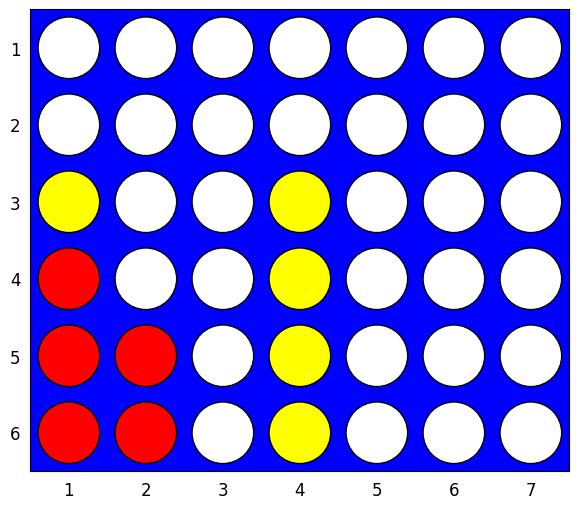

The winner is v-yellow


In [62]:
# With win and block logic added
# Not working well right now
# red bot chose to block even though they could win on that turn


# Set up new game
winner = 'nobody'
board = np.zeros((6,7,2))
plot_connect4(board)
player = 'red'

# Determine which color each player is (red goes first)
human_player = input('Which player would you like to be? Red or yellow? Red goes first.').strip().lower()
if human_player == 'red':
  bot_player = 'yellow'
else:
  bot_player = 'red'

# Determine which model to use
selected_opponent = input('Please select your opponent: "CNN" or "Transformer"').strip().lower()
if selected_opponent == 'cnn':
    # Because I had an issue loading the model
    custom_objects = {
        'softmax_v2': tf.keras.activations.softmax
    }
    model = load_model('best_connect4_cnn.h5', custom_objects=custom_objects)
else:
    model = load_model('best_transformer.h5')


while winner == 'nobody':
    # Check for legal moves, else return 'tie'
    legal = find_legal(board)
    if len(legal) == 0:
        winner = 'tie'
        break
    
    if player == human_player:
        move = input('Pick a move (1-7) for player '+player+': ')
        move = int(move) - 1 # convert player's move to index
        board = update_board(board,human_player,move)
        clear_output()
        plot_connect4(board)

    elif player != human_player:
        print('Bot is thinking...')
        
        # If bot is yellow, flip board for accurate predictions
        if bot_player == 'yellow':
            move = look_for_win(board,bot_player)
            # Ignore model predictions and select winning move if there is one
            if move > -0.5:
                board = update_board(board,bot_player,move)
            # Ensure you block a win on the next turn, even if model doesn't select that move
            else:
                nonlosing_moves = find_all_nonlosers(board,bot_player) # only play nonlosing moves
                if len(nonlosing_moves) == 0: # if you can't block (there are two your moves where your opponent will win)
                    temp_board = np.flip(board, axis = 1) # don't want to actually save this board, just used for predictions
                    model_input = np.expand_dims(temp_board, axis=0) # need to include an extra dimension for sample size = 1
                    bot_moves = model.predict(model_input)[0] # just get the highest probability move
                    move = np.argmax(bot_moves)
                    board = update_board(board,bot_player,move)
                else: # if you can block or don't need to block
                    temp_board = np.flip(board, axis = 1) # don't want to actually save this board, just used for predictions
                    model_input = np.expand_dims(temp_board, axis=0) # need to include an extra dimension for sample size = 1
                    bot_moves = model.predict(model_input)[0][nonlosing_moves] # extract the probabilities for nonlosing moves
                    move = np.argmax(bot_moves)
                    board = update_board(board,bot_player,move)
        else:
            move = look_for_win(board,bot_player)
            # ignore model predictions and select winning move if there is one
            if move > -0.5:
                board = update_board(board,bot_player,move)
            # Ensure you block a win on the next turn, even if model doesn't select that move
            else:
                model_input = np.expand_dims(board, axis=0) # need to include an extra dimension for sample size = 1
                nonlosing_moves = find_all_nonlosers(board, bot_player)
                if len(nonlosing_moves) == 0: # if you can't block (there are two moves where your opponent will win)
                    bot_moves = model.predict(model_input)[0]
                    move = np.argmax(bot_moves) # just get the highest probability move
                    board = update_board(board,bot_player,move)
                else: # if you can block or don't need to block
                    bot_moves = model.predict(model_input)[0][nonlosing_moves] # extract the probabilities for nonlosing moves
                    move = np.argmax(bot_moves)
                    board = update_board(board,bot_player,move)
        clear_output()
        plot_connect4(board)
        
    # Check for a win after either player plays
    winner = check_for_win(board,move)

    # Switch players and go onto the next turn if no one has won
    if player == 'red':
        player = 'yellow'
    else:
        player = 'red'

print('The winner is '+winner)

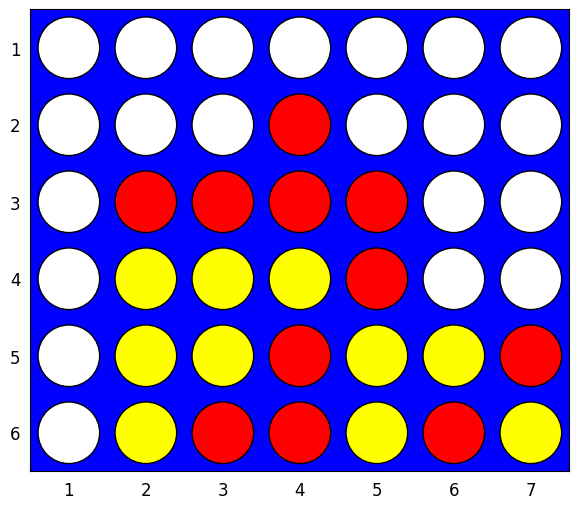

The winner is h-red


In [41]:
# Without nonlosing logic!

# Set up new game
winner = 'nobody'
board = np.zeros((6,7,2))
plot_connect4(board)
player = 'red'

# Determine which color each player is (red goes first)
human_player = input('Which player would you like to be? Red or yellow? Red goes first.').strip().lower()
if human_player == 'red':
  bot_player = 'yellow'
else:
  bot_player = 'red'

# Determine which model to use
selected_opponent = input('Please select your opponent: "CNN" or "Transformer"').strip().lower()
if selected_opponent == 'cnn':
    # Because I had an issue loading the model
    custom_objects = {
        'softmax_v2': tf.keras.activations.softmax
    }
    model = load_model('best_connect4_cnn.h5', custom_objects=custom_objects)
else:
    model = load_model('best_transformer.h5')


while winner == 'nobody':
    # Check for legal moves, else return 'tie'
    legal = find_legal(board)
    if len(legal) == 0:
        winner = 'tie'
        break
    
    if player == human_player:
        move = input('Pick a move (1-7) for player '+player+': ')
        move = int(move) - 1 # convert player's move to index
        board = update_board(board,human_player,move)
        clear_output()
        plot_connect4(board)
        winner = check_for_win(board,move)
    elif player != human_player:
        print('Bot is thinking...')
        
        # If bot is yellow, flip board for accurate predictions
        if bot_player == 'yellow':
            temp_board = np.flip(board, axis = 1) # don't want to actually save this board, just used for predictions
            model_input = np.expand_dims(temp_board, axis=0) # need to include an extra dimension for sample size = 1
            bot_moves = model.predict(model_input)[0] # just get the highest probability move
            move = np.argmax(bot_moves)
            board = update_board(board,bot_player,move)
        else:
            model_input = np.expand_dims(board, axis=0) # need to include an extra dimension for sample size = 1
            bot_moves = model.predict(model_input)[0]
            move = np.argmax(bot_moves) # just get the highest probability move
            board = update_board(board,bot_player,move)

        clear_output()
        plot_connect4(board)

    # Check for a win after either player plays
    winner = check_for_win(board,move)
    
    # Switch players and go onto the next turn if no one has won
    if player == 'red':
        player = 'yellow'
    else:
        player = 'red'

print('The winner is '+winner)